# Making predictions

## Load Model

This notebook loads a model previously trained in [2_keras.ipynb](https://github.com/tensorflow/workshops/tree/master/extras/amld/notebooks/solutions/2_keras.ipynb) or [3_eager.ipynb](https://github.com/tensorflow/workshops/tree/master/extras/amld/notebooks/solutions/3_eager.ipynb) from earlier in the TensorFlow Basics workshop.

**Note** : The code in this notebook is quite Colab specific and won't work with Jupyter.

In [0]:
## Load models from Drive (Colab only).
models_path = '/content/gdrive/My Drive/amld_data/models'
data_path = '/content/gdrive/My Drive/amld_data/zoo_img'
## ... or load models from local machine.
# models_path = './amld_models'
# data_path = './amld_data'
## ... or load models from GCS (Colab only).
# models_path = 'gs://amld-datasets/models'
# data_path = 'gs://amld-datasets/zoo_img_50k'

In [0]:
if models_path.startswith('/content/gdrive/'):
  from google.colab import drive
  drive.mount('/content/gdrive')

if models_path.startswith('gs://'):
  # Keras doesn't read directly from GCS -> download.
  from google.colab import auth
  import os
  os.makedirs('./amld_models', exist_ok=True)
  auth.authenticate_user()
  !gsutil cp -r "$models_path"/\* ./amld_models
  models_path = './amld_models'

!ls -lh "$models_path"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 192K
-rw------- 1 root root 188K Jan 25 01:59 linear.h5
drwx------ 2 root root 4.0K Jan 25 02:00 saved_model


In [0]:
import json, os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

tf.enable_eager_execution()

# version, GPU?, TPU?
tf.__version__, tf.test.is_gpu_available() and tf.test.is_built_with_cuda(), 'COLAB_TPU_ADDR' in os.environ

('1.12.0', True, False)

In [0]:
# Load the label names from the dataset.
labels = [label.strip() for label in tf.gfile.Open('{}/labels.txt'.format(data_path))]
print('\n'.join(['%2d: %s' % (i, label) for i, label in enumerate(labels)]))

 0: camel
 1: crocodile
 2: dolphin
 3: elephant
 4: flamingo
 5: giraffe
 6: kangaroo
 7: lion
 8: monkey
 9: penguin
10: rhinoceros


In [0]:
# Note: with TensorFlow 1.12 the warning "No training configuration found..." is
# expected. It means that you would need to re-attach a optimizer if you want to
# continue the training. Can be safely ignored for evaluation/prediction.
model = tf.keras.models.load_model(os.path.join(models_path, 'linear.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                45067     
Total params: 45,067
Trainable params: 45,067
Non-trainable params: 0
_________________________________________________________________


## Live Predictions

In [0]:
from google.colab import output
import IPython

def predict(img_64):
  """Get Predictions for provided image.
  Args:
    img_64: Raw image data (dtype int).
  Returns:
    A JSON object with the value for "result" being a text representation of the
    top predictions.
  """
  # Reshape image into batch with single image (extra dimension "1").
  preds = model.predict(np.array(img_64, float).reshape([1, 64, 64]))
  # Get top three predictions (reverse argsort).
  top3 = (-preds[0]).argsort()[:3]
  # Return both "probability" and prediction label name.
  result = '\n'.join(['%.3f: %s' % (preds[0, i], labels[i]) for i in top3])
  return IPython.display.JSON(dict(result=result))

output.register_callback('amld.predict', predict)

In [0]:
%%html
<meta name="viewport" content="width=device-width, initial-scale=1, user-scalable=no">
<canvas width="256" height="256" id="canvas" style="border:1px solid black"></canvas><br />
<button id="clear">clear</button><br />
<pre id="output"></pre>
<script>
  let upscaleFactor = 4, halfPenSize = 2
  let canvas = document.getElementById('canvas')
  let output = document.getElementById('output')
  let ctx = canvas.getContext('2d')
  let img_64 = new Uint8Array(64*64)
  let dragging = false
  let timeout
  let predict = () => {
    google.colab.kernel.invokeFunction('amld.predict', [Array.from(img_64)], {}).then(
        obj => output.textContent = obj.data['application/json'].result)
  }
  const getPos = e => {
    let x = e.offsetX, y = e.offsetY
    if (e.touches) {
      const rect = canvas.getBoundingClientRect()
      x = e.touches[0].clientX - rect.left
      y = e.touches[0].clientY - rect.left
    }
    return {
      x: Math.floor((x - 2*halfPenSize*upscaleFactor/2)/upscaleFactor),
      y: Math.floor((y - 2*halfPenSize*upscaleFactor/2)/upscaleFactor),
    }
  }
  const handler = e => {
    const { x, y } = getPos(e)
    ctx.fillStyle = 'black'
    ctx.fillRect(x*upscaleFactor, y*upscaleFactor,
                 2*halfPenSize*upscaleFactor, 2*halfPenSize*upscaleFactor)
    for (let yy = y - halfPenSize; yy < y + halfPenSize; yy++)
      for (let xx = x - halfPenSize; xx < x + halfPenSize; xx++)
        img_64[64*Math.min(63, Math.max(0, yy)) + Math.min(63, Math.max(0, xx))] = 1
    clearTimeout(timeout)
    timeout = setTimeout(predict, 500)
  }
  canvas.addEventListener('touchstart', e => {dragging=true; handler(e)})
  canvas.addEventListener('touchmove', e => {e.preventDefault(); dragging && handler(e)})
  canvas.addEventListener('touchend', () => dragging=false)
  canvas.addEventListener('mousedown', e => {dragging=true; handler(e)})
  canvas.addEventListener('mousemove', e => {dragging && handler(e)})
  canvas.addEventListener('mouseup', () => dragging=false)
  canvas.addEventListener('mouseleave', () => dragging=false)
  document.getElementById('clear').addEventListener('click', () => {
    ctx.fillStyle = 'white'
    ctx.fillRect(0, 0, 64*upscaleFactor, 64*upscaleFactor)
    output.textContent = ''
    img_64 = new Uint8Array(64*64)
  })
</script>

In [0]:
# YOUR ACTION REQUIRED:
# Load another model from 2_keras.ipynb and observe:
# - Do you get better/worse predictions?
# - Do you feel a difference in latency?
# - Can you figure out by how the model "thinks" by providing similar images
#   that yield different predicitions, or different images that yield the same
#   picture?
#--snip
model = tf.keras.models.load_model(os.path.join(models_path, 'conv.h5'))
model.summary()

OSError: ignored

## TensorFlow.js


Read about basic concepts in TensorFlow.js:
https://js.tensorflow.org/tutorials/core-concepts.html

If you find the Colab `%%html` way cumbersome to explore the JS API, then have a try codepen by clicking on the "Try TensorFlow.js" button on https://js.tensorflow.org/

### Basics

In [0]:
# Getting the data of a tensor in TensorFlow.js : Use the async .data() method
# to show the output in the "output" element.
# See output in javascript console (e.g. Chrome developer tools).
# Try also to run the code in Codepen by following the "Try TensorFlow.js" link
# on https://js.tensorflow.org/.
%%html
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@0.14.1/dist/tf.min.js"></script>
<pre id="output"></pre>
<script>
  let output = document.getElementById('output')
  let t = tf.tensor([1, 2, 3])
  output.textContent = t
  // YOUR ACTION REQUIRED:
  // Use "t.data()" to append the tensor's data values to "output.textContent".
  //--snip
  t.data().then(t_data => t_data.forEach(
    (value, idx) => output.textContent += `\n${idx}: ${value}`
  ))

In [0]:
# Get top 3 predictions using TensorFlow Eager.
preds = tf.constant([0.1, 0.5, 0.2, 0.0])
topk = tf.math.top_k(preds, 3)
for idx, value in zip(topk.indices.numpy(), topk.values.numpy()):
  print('idx', idx, 'value', value)

idx 1 value 0.5
idx 2 value 0.2
idx 0 value 0.1


In [0]:
# Implement the same top 3 functionality in TensorFlow.js, showing th eoutput
# in the "output" element.
# See https://js.tensorflow.org/api/latest/index.html#topk
%%html
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@0.14.1/dist/tf.min.js"></script>
<pre id="output"></pre>
<script>
  let output = document.getElementById('output')
  let preds = tf.tensor([0.1, 0.5, 0.2, 0.0])
  // YOUR ACTION REQUIRED:
  // Use tf.topk() to get top 3 predictions in "preds" and append both the
  // index and the value of these predictions to "output".
  //--snip
  const { indices, values } = tf.topk(preds, 3)
  Promise.all([indices.data(), values.data()]).then(indices_values => {
    const [ indices, values ] = indices_values
    indices.forEach((idx, i) =>  {
      output.textContent += `idx ${idx} value ${values[i]}\n`
    })
  })

### Convert Model

We can convert the Keras model into TensorFlow.js format using the Python package `tensorflowjs`.

Read more about importing Keras models:
https://js.tensorflow.org/tutorials/import-keras.html


In [0]:
# Install extra package
!pip install tensorflowjs

    100% |████████████████████████████████| 307kB 11.3MB/s 
    100% |████████████████████████████████| 61kB 24.2MB/s 
    100% |████████████████████████████████| 13.9MB 3.2MB/s 
    100% |████████████████████████████████| 51kB 12.1MB/s 
yellowbrick 0.9 has requirement matplotlib<3.0,>=1.5.1, but you'll have matplotlib 3.0.2 which is incompatible.
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
tensorflow 1.12.0 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.4 which is incompatible.
tensorflow 1.12.0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.2 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.1 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompati

In [0]:
# Specify directory where to store model.
tfjs_model_path = './tfjs/model'
!mkdir -p "$tfjs_model_path"

In [0]:
# Convert model
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, tfjs_model_path)
!ls -lh "$tfjs_model_path"

Using TensorFlow backend.


total 184K
-rw-r--r-- 1 root root 177K Jan 26 16:44 group1-shard1of1
-rw-r--r-- 1 root root  987 Jan 26 16:44 model.json


In [0]:
import json
# You can copy this into the JavaScript code in the next cell if you load a
# model trained on a custom dataset (code below assumes dataset="zoo").
print(json.dumps(labels))

["camel", "crocodile", "dolphin", "elephant", "flamingo", "giraffe", "kangaroo", "lion", "monkey", "penguin", "rhinoceros"]


### Predict in JS

In [0]:
# Make offline predictions using TensorFlow.js:
# 1. Copy above %%html snippet (under "Live Predictions") and below snippet
#    (without the "%%html") into a new file "inddx.html" on your computer.
# 2. You might need to adapt "labels" nad "modelPath".
# 3. Download the converted TensorFlow.js model from above in the same directory.
# 4. Start a http server (e.g. "$ python3 -m http.server").
# 5. Navigate to localhost:8000/ & enjoy.
# (For better drawing, you can also connect to your computer's IP with your cell
#  phone when you're in the same local network...)
%%html
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@0.14.1/dist/tf.min.js"> </script>
<script>
  const labels = ["camel", "crocodile", "dolphin", "elephant", "flamingo", "giraffe", "kangaroo", "lion", "monkey", "penguin", "rhinoceros"]
  const modelPath = './model/model.json'
  let model = null
  tf.loadModel(modelPath).then(response => model = response)
  predict = () => {
    const preds = model.predict(tf.tensor(img_64).reshape([1, 64, -1]))
    const { values, indices } = tf.topk(preds, 3)
    Promise.all([values.data(), indices.data()]).then(data => {
      const [ values, indices ] = data
      output.textContent = ''
      values.forEach((v, i) => output.textContent +=  `${labels[indices[i]]} : ${v.toFixed(3)}\n`)
    })
  }
</script>

### Run http Server

By copying together the content of the two `%%html` cells (without the leading `%%html`!) you can now create a fully functional mini web app that handles user input and performs predictions on-device.

We store the web page in `./tfjs/index.html` and then use `python3 -m http.server` to serve both the html and the model files. The HTTP port is then forwarded to a public address using [ngrok](https://ngrok.com).

In [0]:
# YOUR ACTION REQUIRED:
# Append the content of the two html cells (without the "%%html" line) in this
# Colab below and run the cell. It will create a file "index.html" - you can
# verify this in the "Files" tab on the right.
%%writefile ./tfjs/index.html
<!-- --snip -->
<meta name="viewport" content="width=device-width, initial-scale=1, user-scalable=no">
<canvas width="256" height="256" id="canvas" style="border:1px solid black"></canvas><br />
<button id="clear">clear</button><br />
<pre id="output"></pre>
<script>
  let upscaleFactor = 4, halfPenSize = 2
  let canvas = document.getElementById('canvas')
  let output = document.getElementById('output')
  let ctx = canvas.getContext('2d')
  let img_64 = new Uint8Array(64*64)
  let dragging = false
  let timeout
  let predict = () => {
    google.colab.kernel.invokeFunction('amld.predict', [Array.from(img_64)], {}).then(
        obj => output.textContent = obj.data['application/json'].result)
  }
  const getPos = e => {
    let x = e.offsetX, y = e.offsetY
    if (e.touches) {
      const rect = canvas.getBoundingClientRect()
      x = e.touches[0].clientX - rect.left
      y = e.touches[0].clientY - rect.left
    }
    return {
      x: Math.floor((x - 2*halfPenSize*upscaleFactor/2)/upscaleFactor),
      y: Math.floor((y - 2*halfPenSize*upscaleFactor/2)/upscaleFactor),
    }
  }
  const handler = e => {
    const { x, y } = getPos(e)
    ctx.fillStyle = 'black'
    ctx.fillRect(x*upscaleFactor, y*upscaleFactor,
                 2*halfPenSize*upscaleFactor, 2*halfPenSize*upscaleFactor)
    for (let yy = y - halfPenSize; yy < y + halfPenSize; yy++)
      for (let xx = x - halfPenSize; xx < x + halfPenSize; xx++)
        img_64[64*Math.min(63, Math.max(0, yy)) + Math.min(63, Math.max(0, xx))] = 1
    clearTimeout(timeout)
    timeout = setTimeout(predict, 500)
  }
  canvas.addEventListener('touchstart', e => {dragging=true; handler(e)})
  canvas.addEventListener('touchmove', e => {e.preventDefault(); dragging && handler(e)})
  canvas.addEventListener('touchend', () => dragging=false)
  canvas.addEventListener('mousedown', e => {dragging=true; handler(e)})
  canvas.addEventListener('mousemove', e => {dragging && handler(e)})
  canvas.addEventListener('mouseup', () => dragging=false)
  canvas.addEventListener('mouseleave', () => dragging=false)
  document.getElementById('clear').addEventListener('click', () => {
    ctx.fillStyle = 'white'
    ctx.fillRect(0, 0, 64*upscaleFactor, 64*upscaleFactor)
    output.textContent = ''
    img_64 = new Uint8Array(64*64)
  })
</script>
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@0.14.1/dist/tf.min.js"> </script>
<script>
  const labels = ["camel", "crocodile", "dolphin", "elephant", "flamingo", "giraffe", "kangaroo", "lion", "monkey", "penguin", "rhinoceros"]
  const modelPath = './model/model.json'
  let model = null
  tf.loadModel(modelPath).then(response => model = response)
  predict = () => {
    const preds = model.predict(tf.tensor(img_64).reshape([1, 64, -1]))
    const { values, indices } = tf.topk(preds, 3)
    Promise.all([values.data(), indices.data()]).then(data => {
      const [ values, indices ] = data
      output.textContent = ''
      values.forEach((v, i) => output.textContent +=  `${labels[indices[i]]} : ${v.toFixed(3)}\n`)
    })
  }
</script>

Writing ./tfjs/index.html


In [0]:
# First download ngrok for tunneling.
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip
!ls -lh ./ngrok

--2019-01-25 23:22:46--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.231.75.48, 34.232.181.106, 34.206.253.53, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.231.75.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  --.-KB/s    in 0.1s    

2019-01-25 23:22:46 (43.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
-rwxr-xr-x 1 root root 16M Jul 15  2017 ./ngrok


In [0]:
# Then start a mini web server at a random port...
import random
port = random.randint(1000, 2**16)

!pkill ngrok
!kill $(ps x | grep -v grep | grep http.server | awk '{print $1}') 2>/dev/null

get_ipython().system_raw(
    'cd ./tfjs && python3 -m http.server {} &'
    .format(port)
)

# ...and forward the port using ngrok.
get_ipython().system_raw('./ngrok http {} &'.format(port))

In [0]:
# Get the public address from localhost:4040 (ngrok's web interface).
import time, urllib
time.sleep(1)  # Give ngrok time to startup.
ngrok_data = json.load(urllib.request.urlopen('http://localhost:4040/api/tunnels'))
ngrok_data['tunnels'][0]['public_url']

'http://6874b667.ngrok.io'

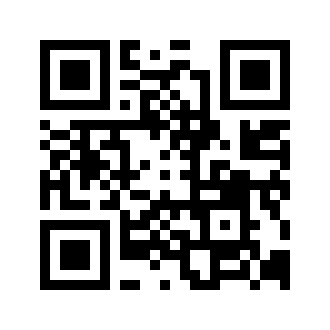

In [0]:
# You can connect to this external address using your mobile phone!
# Once the page is loaded you can turn on flight modus and verify that
# predictions are really generated on-device :-)
!pip install qrcode
import qrcode
qrcode.make(ngrok_data['tunnels'][0]['public_url'])